In [2]:
from pathlib import Path
import json
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

results_dir = Path.cwd() / 'results' / 'bert-results'
# results_dir = Path.cwd() / 'distilbert-results'

test_data_d = {}
REPOS = []

for run_dir in results_dir.iterdir():
    run_name = run_dir.name
    if 'linktype' in (run_name.split('_')) and 'plus' in (run_name.split('_')):
        repo = run_name.split('_')[0]
        REPOS.append(repo)
        
        print(repo)
        
        with (run_dir / 'run_config.json').open('r', encoding='utf8') as f:
            run_config = json.load(f)
        test_output = np.load(run_dir / 'test_output.npz')
        
        filepath = "splits/"+repo.lower()+'_plus.csv'
        data = pd.read_csv(filepath, encoding="UTF-8", low_memory=False)
        test_data = data[data['split']=='test'].sort_values(by='sample_index')
        
        preds = test_output['logits'].argmax(axis=1)
        
        test_data['labels'] = test_output['labels']
        test_data['preds'] = preds
        
        correct3 = []
        for i, res in zip(test_output['labels'], test_output['logits']):
            temp = res.argsort()[-3:][::-1]
            correct3.append(i in(temp))
            
        test_data['correct3'] = correct3
        
        correct = []
        
        filename = '../data/processed/issues_'+repo.lower()+'.csv'
        issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=";", index_col='issue_id')
        
        issue_text_data = issues[['title', 'description']]
        
        test_text_data = test_data.merge(issue_text_data, left_on='issue_id_1', right_on='issue_id')
        test_text_data = test_text_data.merge(issue_text_data, left_on='issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))
       
        no_lab = len(run_config['label_names'])
        bla = np.arange(0,no_lab,1)
        temp = pd.DataFrame([bla, run_config['label_names']]).transpose()
#         print(run_config['label_names'])
        label_dict = dict(temp.values)
#         print(str(label_dict))
        
        test_text_data['labels_text'] = test_text_data['labels'].map(label_dict)
        test_text_data['preds_text'] = test_text_data['preds'].map(label_dict)
        
        test_text_data.reset_index(inplace = True)
        
        for i in test_text_data.index:
            lab = test_text_data['labels'].iloc[i]
            pre = test_text_data['preds'].iloc[i]
            
            correct.append((lab==pre))
            
        test_text_data['correct'] = correct       
        
        test_data_d[repo] = test_text_data
        
        conf_mat = confusion_matrix(
            test_output['labels'],
            test_output['logits'].argmax(axis=1),
        )
        conf_mat = np.round(conf_mat, 2)
    
        conf_mat_df = pd.DataFrame(conf_mat, columns=run_config['label_names'], index=run_config['label_names'])
#         print(conf_mat_df)

secondlife


FileNotFoundError: [Errno 2] No such file or directory: 'splits/secondlife_plus.csv'

In [184]:
REPOS.remove('mojang')

In [185]:
x = 0
for r in REPOS:
    test_data = test_data_d[r]
    print(r)
    print(len(test_data[test_data['correct3']==True])/len(test_data))
    x += len(test_data[test_data['correct3']==True])/len(test_data)-(len(test_data[test_data['correct']==True])/len(test_data))
print(x/14)

secondlife
0.8851351351351351
jira
0.9713976803617063
jiraecosystem
0.8724402730375427
hyperledger
0.947973713033954
inteldaos
0.8936170212765957
sakai
0.8978675645342312
mariadb
0.9027059896625114
apache
0.878850298487536
mongodb
0.9378872713699141
jfrog
0.8825214899713467
sonatype
0.8224974200206399
redhat
0.8843827386026875
spring
0.9218312052320149
qt
0.896814404432133
0.17838827117570086


In [127]:
import random

LTs = ['Epic', 'Subtask', 'Relate',
       'Non-Link', 'Clone', 'Block',
       'Incorporate', 'Duplicate','Depend',
       'Cause']

analysis_true_df = pd.DataFrame()

for r in REPOS:
    test_data = test_data_d[r]
    for lt in LTs:
        if lt in test_data.labels_text.unique():
            temp_df = test_data[(test_data['labels_text'] == lt) & (test_data['correct'] == True)]
            samplesize = min(10,len(temp_df))
            temp_sample = temp_df.sample(samplesize)
            temp_sample['source'] = r
            analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])

analysis_false_df = pd.DataFrame()

for r in REPOS:
    test_data = test_data_d[r]
    for lt in LTs:
        if lt in test_data.labels_text.unique():
            temp_df = test_data[(test_data['labels_text'] == lt) & (test_data['correct'] == False)]
            samplesize = min(10,len(temp_df))
            temp_sample = temp_df.sample(samplesize)
            temp_sample['source'] = r
            analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
            
analysis_true_df.to_csv('QualAnalysis_true.csv', sep =';')
analysis_false_df.to_csv('QualAnalysis_false.csv', sep =';')

<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'label

<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'label

<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'label

<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_true_df = analysis_true_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'label

<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 

<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 

<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 'labels_text', 'preds_text', 'correct', 'title_1', 'description_1', 'title_2', 'description_2']])
<ipython-input-127-6e2558e725f0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_false_df = analysis_false_df.append(temp_sample[['source', 'issue_id_1', 'issue_id_2', 

In [128]:
for r in REPOS:
    blub = test_data_d[r]
    
    titles_1 = blub['title_1']
    title_lengths_1 = (titles_1.str.count(' ')+1).fillna(0).astype(np.int)
    desc_1 = blub['description_1']
    desc_lengths_1 = (desc_1.str.count(' ')+1).fillna(0).astype(np.int)
    
    titles_2 = blub['title_2']
    title_lengths_2 = (titles_2.str.count(' ')+1).fillna(0).astype(np.int)
    desc_2 = blub['description_2']
    desc_lengths_2 = (desc_2.str.count(' ')+1).fillna(0).astype(np.int)
    
    blub['title_len_1'] = title_lengths_1
    blub['desc_len_1'] = desc_lengths_1
    
    blub['title_len_2'] = title_lengths_2
    blub['desc_len_2'] = desc_lengths_2
    
    blub['title_len'] = blub['title_len_1']+blub['title_len_2']
    blub['desc_len'] = blub['desc_len_1']+blub['desc_len_2']
    
    blub['total_len'] = blub['desc_len']+blub['title_len']
    
    test_data_d[r] = blub

<ipython-input-128-ac564dea12b9>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  title_lengths_1 = (titles_1.str.count(' ')+1).fillna(0).astype(np.int)
<ipython-input-128-ac564dea12b9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inform

<ipython-input-128-ac564dea12b9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  desc_lengths_1 = (desc_1.str.count(' ')+1).fillna(0).astype(np.int)
<ipython-input-128-ac564dea12b9>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informat

<ipython-input-128-ac564dea12b9>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  desc_lengths_2 = (desc_2.str.count(' ')+1).fillna(0).astype(np.int)
<ipython-input-128-ac564dea12b9>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informat

<ipython-input-128-ac564dea12b9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  desc_lengths_1 = (desc_1.str.count(' ')+1).fillna(0).astype(np.int)
<ipython-input-128-ac564dea12b9>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informat

In [129]:
relevant_types = ['Epic', 'Subtask', 'Relate',
       'Non-Link', 'Clone', 'Block',
       'Incorporate', 'Duplicate','Depend',
       'Cause']

median = []
mean = []
std = []

for s in REPOS:
    test_data = test_data_d[s]
    
    temp_df = test_data[test_data['correct'] == True]
    
    temp_median = [s]
    temp_mean = [s]
    temp_std = [s]
    
    for i in relevant_types:
        if i in set(temp_df['labels_text'].unique()):
            temp_link_df = temp_df[temp_df['labels_text']==i]
            temp_median.append(temp_link_df['total_len'].median())
            temp_mean.append(temp_link_df['total_len'].mean())
            temp_std.append(temp_link_df['total_len'].std())
        else:
            temp_median.append("not in repo")
            temp_mean.append("not in repo")
            temp_std.append("not in repo")
            
    median.append(temp_median)
    mean.append(temp_mean)
    std.append(temp_std)

In [130]:
cols = ['Repo', 'Epic', 'Subtask', 'Relate',
       'Non-Link', 'Clone', 'Block',
       'Incorporate', 'Duplicate','Depend',
       'Cause']

median_df = pd.DataFrame(median, columns = cols)
mean_df = pd.DataFrame(mean, columns = cols)
std_df = pd.DataFrame(std, columns = cols)

In [131]:
relevant_types = ['Epic', 'Subtask', 'Relate',
       'Non-Link', 'Clone', 'Block',
       'Incorporate', 'Duplicate','Depend',
       'Cause']

median = []
mean = []
std = []

for s in REPOS:
    test_data = test_data_d[s]
    
    temp_df = test_data[test_data['correct'] == False]
    
    temp_median = [s]
    temp_mean = [s]
    temp_std = [s]
    
    for i in relevant_types:
        if i in set(temp_df['labels_text'].unique()):
            temp_link_df = temp_df[temp_df['labels_text']==i]
            temp_median.append(temp_link_df['total_len'].median())
            temp_mean.append(temp_link_df['total_len'].mean())
            temp_std.append(temp_link_df['total_len'].std())
        else:
            temp_median.append("not in repo")
            temp_mean.append("not in repo")
            temp_std.append("not in repo")
            
    median.append(temp_median)
    mean.append(temp_mean)
    std.append(temp_std)

In [132]:
cols = ['Repo', 'Epic', 'Subtask', 'Relate',
       'Non-Link', 'Clone', 'Block',
       'Incorporate', 'Duplicate','Depend',
       'Cause']

median_df = pd.DataFrame(median, columns = cols)
mean_df = pd.DataFrame(mean, columns = cols)
std_df = pd.DataFrame(std, columns = cols)

In [133]:
bla = median_df.set_index('Repo')

bla

,Epic,Subtask,Relate,Non-Link,Clone,Block,Incorporate,Duplicate,Depend,Cause
Repo,,,,,,,,,,
secondlife,not in repo,119.0,114.0,118.0,227.5,not in repo,99.0,not in repo,105.5,not in repo
jira,not in repo,104.0,195.0,166.0,191.0,not in repo,177.0,195.5,not in repo,261.0
jiraecosystem,107.0,71.5,101.5,126.5,175.0,106.5,88.0,104.0,106.0,146.5
hyperledger,53.0,78.0,144.5,132.5,201.0,138.0,not in repo,125.0,not in repo,not in repo
inteldaos,not in repo,77.0,164.0,221.5,1766.5,288.0,not in repo,348.0,not in repo,not in repo
sakai,not in repo,150.5,150.5,149.5,146.0,not in repo,185.0,167.5,155.0,not in repo
mariadb,129.0,164.0,427.0,324.0,not in repo,311.0,292.0,422.5,not in repo,394.0
apache,102.5,122.0,146.0,110.5,124.0,121.0,134.0,156.5,124.0,181.0
mongodb,129.0,59.0,150.5,115.0,not in repo,not in repo,not in repo,145.0,128.0,179.0


In [134]:
bla = median_df.set_index('Repo')

bla

,Epic,Subtask,Relate,Non-Link,Clone,Block,Incorporate,Duplicate,Depend,Cause
Repo,,,,,,,,,,
secondlife,not in repo,119.0,114.0,118.0,227.5,not in repo,99.0,not in repo,105.5,not in repo
jira,not in repo,104.0,195.0,166.0,191.0,not in repo,177.0,195.5,not in repo,261.0
jiraecosystem,107.0,71.5,101.5,126.5,175.0,106.5,88.0,104.0,106.0,146.5
hyperledger,53.0,78.0,144.5,132.5,201.0,138.0,not in repo,125.0,not in repo,not in repo
inteldaos,not in repo,77.0,164.0,221.5,1766.5,288.0,not in repo,348.0,not in repo,not in repo
sakai,not in repo,150.5,150.5,149.5,146.0,not in repo,185.0,167.5,155.0,not in repo
mariadb,129.0,164.0,427.0,324.0,not in repo,311.0,292.0,422.5,not in repo,394.0
apache,102.5,122.0,146.0,110.5,124.0,121.0,134.0,156.5,124.0,181.0
mongodb,129.0,59.0,150.5,115.0,not in repo,not in repo,not in repo,145.0,128.0,179.0


In [135]:
all_test_data = pd.DataFrame()

for r in REPOS:
    test_data = test_data_d[r]
    test_data['repo'] = r
    all_test_data = all_test_data.append(test_data)


<ipython-input-135-375b9685147e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_test_data = all_test_data.append(test_data)
<ipython-input-135-375b9685147e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_test_data = all_test_data.append(test_data)
<ipython-input-135-375b9685147e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_test_data = all_test_data.append(test_data)
<ipython-input-135-375b9685147e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_test_data = all_test_data.append(test_data)
<ipython-input-135-375b9685147e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

In [136]:
all_test_data[:10].columns

Index(['index', 'split', 'sample_index', 'issue_id_1', 'issue_id_2', 'labels',
       'preds', 'title_1', 'description_1', 'title_2', 'description_2',
       'labels_text', 'preds_text', 'correct', 'title_len_1', 'desc_len_1',
       'title_len_2', 'desc_len_2', 'title_len', 'desc_len', 'total_len',
       'repo'],
      dtype='object')

In [137]:
bla = pd.pivot_table(all_test_data, values='total_len', index=['repo', 'correct'],
                    columns=['labels_text'], aggfunc=np.median)[['Relate', 'Duplicate', 'Subtask', 
                                                           'Depend', 'Clone', 'Incorporate',
                                                           'Epic', 'Block', 'Cause', 'Non-Link']]

round(bla, 2)

labels_text            Relate  Duplicate  Subtask  Depend   Clone  \
repo          correct                                               
apache        False     146.0      156.5    122.0   124.0   124.0   
              True      160.0      163.0     85.0   103.0    67.0   
hyperledger   False     144.5      125.0     78.0     NaN   201.0   
              True      189.0      207.0     74.0     NaN    92.0   
inteldaos     False     164.0      348.0     77.0     NaN  1766.5   
              True      270.0      442.5    110.0     NaN   107.0   
jfrog         False     134.0      123.0     82.5    66.5     NaN   
              True      186.0      193.5      9.0    35.0     NaN   
jira          False     195.0      195.5    104.0     NaN   191.0   
              True      194.0      175.0     74.0     NaN   171.5   
jiraecosystem False     101.5      104.0     71.5   106.0   175.0   
              True      125.0      102.0     31.0   156.5   120.0   
mariadb       False     427.0      422.5    164.0     NaN     NaN   
              True      460.5      492.0     70.0     NaN     NaN   
mojang        False     146.0      150.0      NaN     NaN     NaN   
              True      159.0      145.0      NaN     NaN     NaN   
mongodb       False     150.5      145.0     59.0   128.0     NaN   
              True      167.0      171.5     76.0    85.0     NaN   
qt            False     175.0      191.0    119.5   141.0     NaN   
              True      192.5      184.0     42.0    91.0     NaN   
redhat        False     120.0      134.0     85.0     NaN   102.0   
              True      144.0      128.0     70.0     NaN   118.0   
sakai         False     150.5      167.5    150.5   155.0   146.0   
              True      181.0      137.5    105.0   154.5   141.0   
secondlife    False     114.0        NaN    119.0   105.5   227.5   
              True      163.0        NaN     67.5   212.5    40.5   
sonatype      False     156.0      236.5    110.0   114.0     NaN   
              True      128.0      149.5     54.5    75.0     NaN   
spring        False     140.0      164.0     65.0   125.0     NaN   
              True      178.0      198.5     54.5    86.0     NaN   

labels_text            Incorporate   Epic  Block  Cause  Non-Link  
repo          correct                                              
apache        False          134.0  102.5  121.0  181.0     110.5  
              True           113.0   97.0   95.0  186.0     134.0  
hyperledger   False            NaN   53.0  138.0    NaN     132.5  
              True             NaN   96.5  140.0    NaN      96.0  
inteldaos     False            NaN    NaN  288.0    NaN     221.5  
              True             NaN    NaN  215.0    NaN     170.0  
jfrog         False          237.0    NaN    NaN    NaN      70.5  
              True             NaN    NaN    NaN    NaN     134.0  
jira          False          177.0    NaN    NaN  261.0     166.0  
              True           180.0    NaN    NaN  257.0     171.0  
jiraecosystem False           88.0  107.0  106.5  146.5     126.5  
              True            99.0   50.0   65.0  167.5      84.0  
mariadb       False          292.0  129.0  311.0  394.0     324.0  
              True           159.0   92.0  317.0  478.0     343.0  
mojang        False            NaN    NaN    NaN    NaN     130.0  
              True             NaN    NaN    NaN    NaN     110.0  
mongodb       False            NaN  129.0    NaN  179.0     115.0  
              True             NaN   67.0    NaN  164.0     118.0  
qt            False            NaN  145.0    NaN    NaN     165.5  
              True             NaN   88.0    NaN    NaN     156.0  
redhat        False          116.0    NaN  114.0  140.0     101.5  
              True            84.0    NaN   83.0  160.5     116.0  
sakai         False          185.0    NaN    NaN    NaN     149.5  
              True            88.0    NaN    NaN    NaN     138.0  
secondlife    False    

In [138]:
blx = all_test_data[all_test_data['labels_text'].isin(['Relate', 'Duplicate', 'Subtask', 
                                                           'Depend', 'Clone', 'Incorporate',
                                                           'Epic', 'Block', 'Cause', 'Non-Link'])]

(0.0, 1000.0)

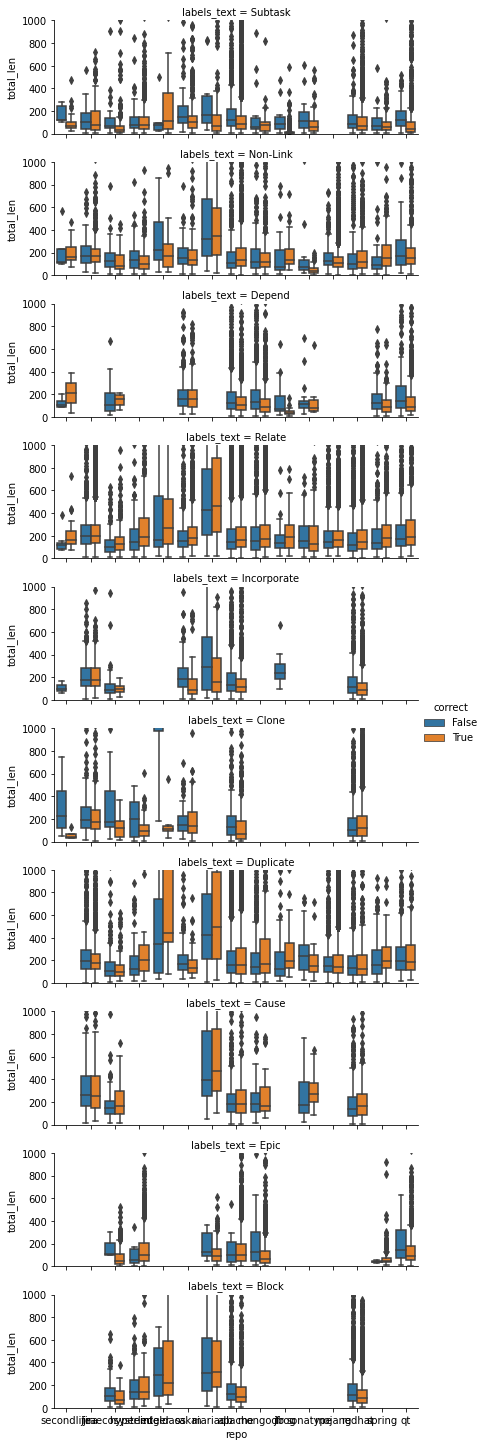

In [139]:
sns.catplot(x="repo", y="total_len", row='labels_text', hue="correct", kind="box", data=blx, height=2, aspect=3)

plt.ylim(0, 1000)

In [145]:
a = all_test_data[(all_test_data['preds_text']=='Relate')&(all_test_data['correct']==False)]
b = all_test_data[(all_test_data['correct']==True)]
c = all_test_data[(all_test_data['preds_text']!='Relate')&(all_test_data['correct']==False)]

In [149]:
for lt in sorted(a.labels_text.unique()):
    print(lt)
    print(a[a['labels_text']==lt]['total_len'].mean())

Block
226.181956411556
Bonfire Testing
243.5185185185185
Breaks
284.9300518134715
Cause
342.90465631929044
Clone
327.07238605898124
Depend
224.4771210676835
Detail
173.04545454545453
Documented
221.8
Duplicate
292.6349444611228
Epic
199.0909090909091
Fix
389.0
Follow
254.96238244514106
Incorporate
265.92514395393476
Non-Link
276.28983050847455
Parent-Child
116.0
Replace
301.44174757281553
Require
240.40408163265306
Split
302.65384615384613
Subtask
196.73920704845816
Supercede
247.66760563380282
Trigger
384.3181818181818
finish-start
213.66666666666666


In [150]:
for lt in sorted(b.labels_text.unique()):
    print(lt)
    print(b[b['labels_text']==lt]['total_len'].mean())

Block
216.90100712355687
Bonfire Testing
228.0625
Breaks
221.48805460750853
Cause
332.20028208744714
Clone
217.731884057971
Depend
157.44580584354384
Detail
49.29235880398671
Documented
258.7661016949153
Duplicate
245.26691662599282
Epic
152.18241000765892
Fix
178.0
Follow
160.668903803132
Incorporate
176.4381846635368
Non-Link
199.34471419576016
Parent-Child
184.66666666666666
Relate
288.9149835360004
Replace
574.1457286432161
Require
178.52919708029196
Split
274.41614906832297
Subtask
142.25409417586303
Supercede
186.87272727272727
Trigger
156.83333333333334
Verify
439.5
finish-start
108.15384615384616


In [151]:
for lt in sorted(c.labels_text.unique()):
    print(lt)
    print(c[c['labels_text']==lt]['total_len'].mean())

Block
197.33429602888086
Bonfire Testing
210.6153846153846
Breaks
227.00523560209425
Cause
265.99049429657794
Clone
222.57894736842104
Depend
193.0
Detail
167.17241379310346
Documented
320.62857142857143
Duplicate
803.8209245742092
Epic
147.03488372093022
Fix
619.5
Follow
245.52307692307693
Incorporate
192.3128054740958
Non-Link
204.2045871559633
Parent-Child
105.5
Relate
260.1877163326089
Replace
1097.900900900901
Require
165.8048780487805
Split
249.31638418079095
Subtask
169.02006018054163
Supercede
199.76923076923077
Trigger
314.6666666666667
finish-start
204.0
